# CSE4224 Project 2
#### Grant Butler | gbutler2020@my.fit.edu

#### Data Retrieval/Cleaning:
Here, I will use the Spotify API to get the audio features of the tracks in my library, and create a cleaned pandas dataframe to be used with PCA and t-SNE after.

In [1]:
# connect to spotify api

from dotenv import dotenv_values
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# use dotenv to import api creds
secrets = dotenv_values(".env")

# making authentication manager for spotipy to communicate with spotify
auth_manager = SpotifyClientCredentials(client_id=secrets["SPOTIPY_CLIENT_ID"],
                                        client_secret=secrets["SPOTIPY_CLIENT_SECRET"])


sp = spotipy.Spotify(auth_manager=auth_manager)  # making spotipy object
sp.trace = False  # no debugging needed

In [2]:
# getting track ids from playlist

# grabbing the track ids and adding them to an array passed into them
def show_tracks(results, uriArray):
    for i, item in enumerate(results['items']):
        track = item['track']
        uriArray.append(track['id'])

# taking in the tracks from the playlist and grabbing the ids before returning them to a list
def get_playlist_track_ids(username, playlist_id):
    track_ids = []  # to store track ids
    playlist = sp.user_playlist(username, playlist_id)  # get playlist
    tracks = playlist['tracks']  # getting tracks from playlist

    # loop through the tracks and append them with helper function
    while tracks['next']:
        tracks = sp.next(tracks)
        show_tracks(tracks, track_ids)
    return track_ids


track_ids = get_playlist_track_ids(secrets['SPOTIFY_USERNAME'],
                                   secrets['PLAYLIST_ID'])

print(track_ids)

['0KAKemTcqJryyhhZqHfrx9', '6yLKMg5vY28owSknvgwVf5', '3hUwFkfeCUOVOMKy9iKDTw', '4LrFMFEu8tc8DKm4VXGnJd', '5e5jcV3KlTpLTh1IWl6kox', '37fHxKAICYRDmYaTujdiBl', '68ClfNyV71AjdTfGIyu4Gx', '14ny3vlL25p6Vix2Sb8k1b', '5QjoIwD2oUBUUlrHpZa1nZ', '32XPs7Frm2dQRI4BraStaX', '5lLLvKIRr5k8otmyZJPyc6', '51HiWFC8v4oJNClRYbzpGl', '43FkY9svV70r8PmBL7ypUh', '7dvtNWoHd3ioEBmIl0s3In', '1u42hFacJ1Bs8H9GX2O8z3', '31er0BSLvpfLCQmuTGO8vm', '3xvCFEGjWycuWkgtvnLOI8', '7Db3lXFuVJdx5Xo9ghWw1O', '7dfrQpUowh5jj9uJUcLAqD', '4lcaWQwftxlVrYamCSXeyU', '5jMc7pAGFQ5lRqfaM7AsU5', '5cD4lbcDJ5jEkar2sW2roc', '5KaIIT6ijzJvlZPPiJby36', '4oLjFQGMuljNXPVXDYlCjQ', '3Fp4Fk3LGPGCzKcthSDXr9', '076axVCuzmW8FGEP7Btd7X', '72rumPRo4OEWIJXnH3y79o', '5KUNwkaNf8l5A9sXZhiCgI', '34aM4AadnV3foQ1cadQYr9', '172qmfzd42sdLySmnmtlFZ', '1rOUmfzzwsIh346zCG5vPw', '5ivXYN8XooE2s4vDc6Lg4T', '36lNDeaRf8F8aYaP0zaHpm', '0IpnZchq8ek2A6pGEP2Qb1', '0axytamcq1Gd4qZD5xlDR9', '0d8ONGx43ZprlHlmLZODpD', '7p2mwDoEBIQw927JW59cwE', '4sFyLyuJOUVMDcaSg1oHEa', '33BRNcBN01

In [3]:
import json

# helper function to split up the bigger list of track ids (spotify api limits to 100 tracks)
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

# taking in a chunk at a time, ensuring they are strings, and then adding on the features and returning them
def get_audio_features(track_ids):
    audio_features = []
    for chunk in chunks(track_ids, 100):
        chunk = [str(track_id) for track_id in chunk]
        audio_features.extend(sp.audio_features(chunk))
    return audio_features

audio_features = get_audio_features(track_ids)
print(json.dumps(audio_features, indent=2))

[
  {
    "danceability": 0.705,
    "energy": 0.63,
    "key": 9,
    "loudness": -8.853,
    "mode": 0,
    "speechiness": 0.0595,
    "acousticness": 0.618,
    "instrumentalness": 5.01e-05,
    "liveness": 0.103,
    "valence": 0.757,
    "tempo": 92.065,
    "type": "audio_features",
    "id": "0KAKemTcqJryyhhZqHfrx9",
    "uri": "spotify:track:0KAKemTcqJryyhhZqHfrx9",
    "track_href": "https://api.spotify.com/v1/tracks/0KAKemTcqJryyhhZqHfrx9",
    "analysis_url": "https://api.spotify.com/v1/audio-analysis/0KAKemTcqJryyhhZqHfrx9",
    "duration_ms": 281693,
    "time_signature": 4
  },
  {
    "danceability": 0.444,
    "energy": 0.389,
    "key": 9,
    "loudness": -12.101,
    "mode": 0,
    "speechiness": 0.0621,
    "acousticness": 0.767,
    "instrumentalness": 1.79e-06,
    "liveness": 0.21,
    "valence": 0.591,
    "tempo": 138.385,
    "type": "audio_features",
    "id": "6yLKMg5vY28owSknvgwVf5",
    "uri": "spotify:track:6yLKMg5vY28owSknvgwVf5",
    "track_href": "https

In [4]:
import pandas as pd

# ensuring there are no entries without data
cleaned_features = [item for item in audio_features if item is not None]

# making dataframe from the list of dicts
df = pd.DataFrame(cleaned_features)

# remove fields that have no bearing on analysis
fields_to_remove = ["analysis_url", "track_href", "type", "uri"]
df = df.drop(columns=fields_to_remove)

print(df)

      danceability  energy  key  loudness  mode  speechiness  acousticness  \
0            0.705   0.630    9    -8.853     0       0.0595        0.6180   
1            0.444   0.389    9   -12.101     0       0.0621        0.7670   
2            0.624   0.687    0    -6.398     1       0.0314        0.1290   
3            0.716   0.615    7    -5.255     0       0.0319        0.8650   
4            0.425   0.432   10    -8.598     0       0.0410        0.6310   
...            ...     ...  ...       ...   ...          ...           ...   
1134         0.608   0.504    4    -9.279     1       0.0302        0.0264   
1135         0.357   0.527   11    -7.612     0       0.0445        0.3030   
1136         0.832   0.454    6   -13.399     0       0.0728        0.4330   
1137         0.622   0.785    7    -7.018     1       0.0300        0.1340   
1138         0.483   0.846    0    -6.235     1       0.0587        0.4220   

      instrumentalness  liveness  valence    tempo             

#### PCA Dimensional Reduction:

Using PCA, I hope to reduce the number of dimensions that t-SNE needs to work with.

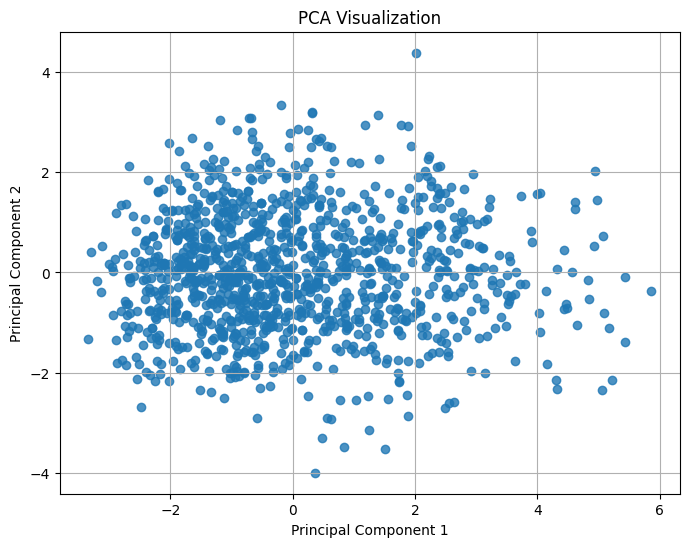

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# remove ids for numeric data only
df_numeric = df.drop(columns='id')

# use standard scaler to centeralize and normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

# apply PCA
pca = PCA(n_components=2) # only 2 dimensions for visualization
X_pca = pca.fit_transform(X_scaled)

# visualize PCA
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.8)
plt.title('PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# Visualize PCA in 3D
# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], alpha=0.8)
# ax.set_title('PCA Visualization in 3D')
# ax.set_xlabel('Principal Component 1')
# ax.set_ylabel('Principal Component 2')
# ax.set_zlabel('Principal Component 3')
# plt.grid(True)
# plt.show()

In [6]:
# checking loadings of principal components
loadings = pca.components_

loadings_df = pd.DataFrame(loadings, columns=df_numeric.columns)

print(loadings_df)

   danceability    energy       key  loudness      mode  speechiness  \
0     -0.265783 -0.498250 -0.035028 -0.458074  0.083484    -0.143680   
1     -0.528189  0.205762 -0.174338  0.255297  0.336301    -0.111898   

   acousticness  instrumentalness  liveness   valence     tempo  duration_ms  \
0      0.456800          0.203821 -0.079212 -0.374538 -0.071905     0.005153   
1     -0.186799         -0.130309  0.101211 -0.332741  0.303027     0.380983   

   time_signature  
0       -0.201184  
1       -0.218360  


Principal Component 1: Explained Variance Ratio = 0.2360
Principal Component 2: Explained Variance Ratio = 0.1094


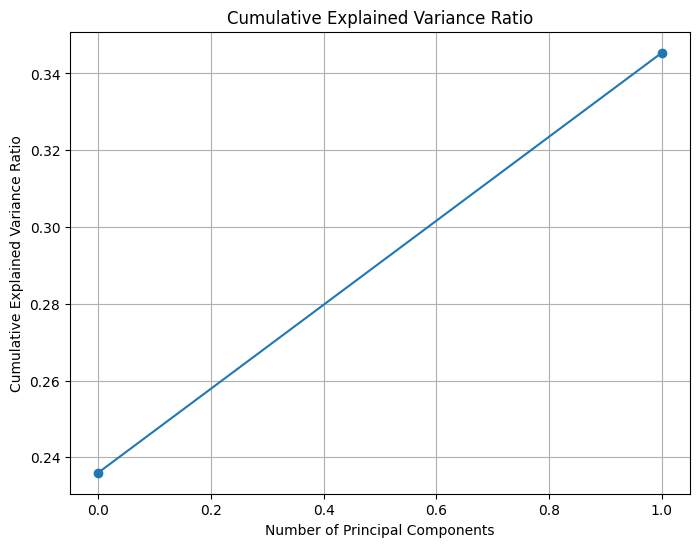

In [7]:
import numpy as np

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Print the explained variance ratio for each component
for i, ratio in enumerate(explained_variance_ratio):
    print(f"Principal Component {i + 1}: Explained Variance Ratio = {ratio:.4f}")

# Plot the cumulative explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(explained_variance_ratio), marker='o', linestyle='-')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [8]:


# sort the loadings to be the most impactful first

loadings_diff = np.abs(np.diff(loadings, axis=0))
loadings_diff_sum = loadings_diff.sum(axis=0)
loadings_diff_df = pd.DataFrame(
    loadings_diff_sum, index=df_numeric.columns, columns=['Sum of Loadings Diff'])

loadings_diff_sorted = loadings_diff_df.sort_values(by='Sum of Loadings Diff', ascending=False)

print(loadings_diff_sorted)

                  Sum of Loadings Diff
loudness                      0.713371
energy                        0.704012
acousticness                  0.643599
duration_ms                   0.375830
tempo                         0.374933
instrumentalness              0.334130
danceability                  0.262406
mode                          0.252817
liveness                      0.180422
key                           0.139310
valence                       0.041797
speechiness                   0.031782
time_signature                0.017176


#### Apply t-SNE on PCA Data

Using *t*-SNE on data from PCA.

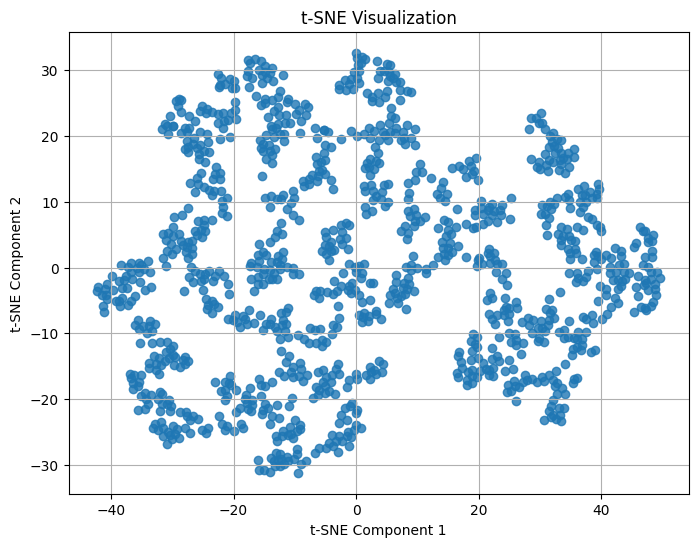

In [9]:
from sklearn.manifold import TSNE

# using 2 components for t-SNE for visualization after reducing with PCA
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

# t-SNE results
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.8)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.show()

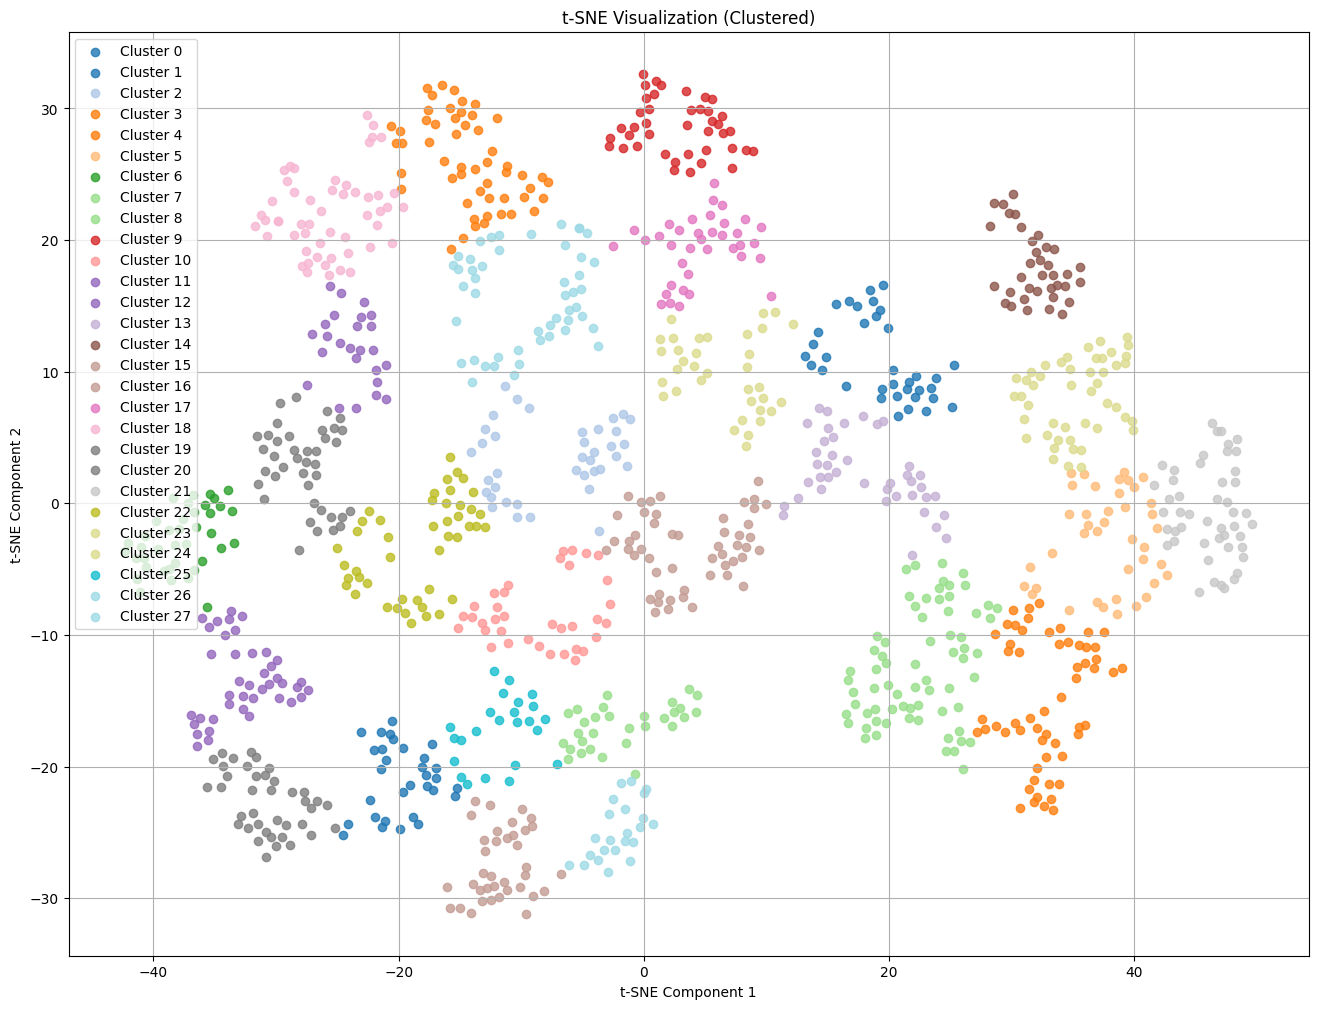

In [10]:
# using k-means to group the clusters and color them based on that

from sklearn.cluster import KMeans

num_clusters = 28

# apply k-means to t-SNE results
kmeans = KMeans(n_clusters=num_clusters, random_state=523)
clusters = kmeans.fit_predict(X_tsne)

colors = plt.cm.tab20(np.linspace(0, 1, len(np.unique(clusters))))

plt.figure(figsize=(16, 12))
for cluster_id, color in zip(np.unique(clusters), colors):
    cluster_indices = np.where(clusters == cluster_id)[0]
    plt.scatter(X_tsne[cluster_indices, 0], X_tsne[cluster_indices,
                1], label=f'Cluster {cluster_id}', color=color, alpha=0.8)
plt.title('t-SNE Visualization (Clustered)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend() # legends for whether you see which cluster is which
plt.grid(True)
plt.show()

In [11]:
# exporting the track ids with cluster information 
cluster_track_ids = {}
clusters = clusters.astype(int)
cluster_track_ids = [{'track_id': track_id, 'cluster_label': int(cluster_label)}
                     for track_id, cluster_label in zip(track_ids, clusters)]

sorted_tracks = sorted(cluster_track_ids, key=lambda x: x['cluster_label'])

with open('clustered_track_ids.json', 'w') as f:
    json.dump(sorted_tracks, f, indent=4)

In [12]:
from spotipy.oauth2 import SpotifyOAuth

with open('clustered_track_ids.json', 'r') as f:
    sorted_data = json.load(f)

sp_2 = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=secrets['SPOTIPY_CLIENT_ID'], 
                                                 client_secret=secrets['SPOTIPY_CLIENT_SECRET'], 
                                                 redirect_uri='http://127.0.0.1',
                                                 scope='playlist-modify-public'))

base_playlist_id = '263kh2wImQQUwntoXUjbvP'

for cluster_label in range(num_clusters):
    temp_tracks = [item['track_id'] for item in sorted_data if item['cluster_label'] == cluster_label]

    playlist_name = f'tsne eg cluster {cluster_label}'
    new_playlist = sp_2.user_playlist_create(sp_2.me()['id'], playlist_name, public=True)

    sp_2.playlist_add_items(new_playlist['id'], temp_tracks)